In [1]:
#import some necessary librairies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points



In [2]:
# subprocess를 이용하여 리눅스 커맨드를 실행, 그에따른 결과값을 check_output으로 출력
from subprocess import check_output
print(check_output(["ls"]).decode("utf8")) #check the files available in the directory

Untitled.ipynb
test.csv
train.csv



In [3]:
#import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Data Preprocessing
### Outlier

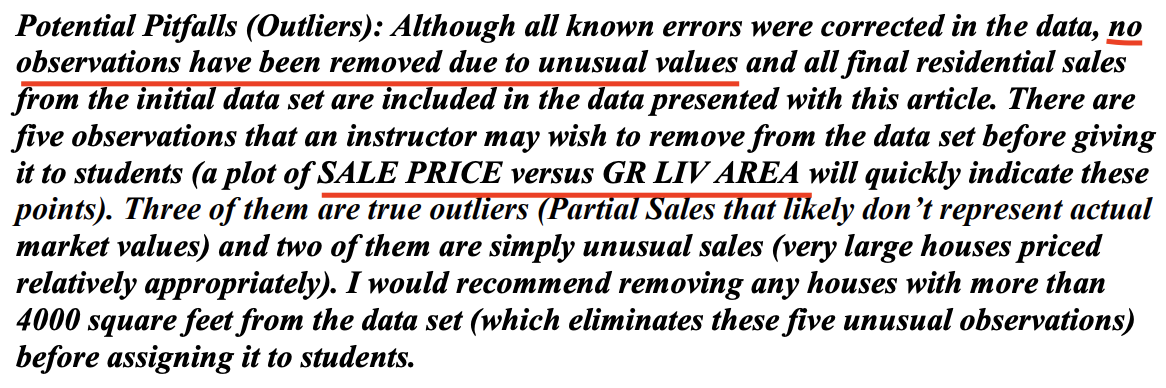
#### Ames 데이터셋에 대한 설명 중, Outlier를 제거하지 않은채 배포하였다고 명시되어 있는걸 인지합시다. 명시되어 있는대로 GrLiveArea와 SalesPrice를 Plot해봅시다.

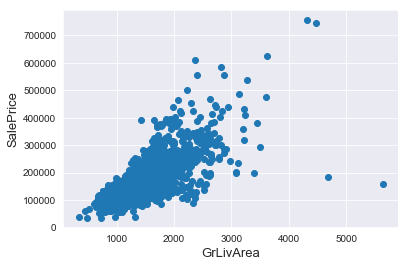

In [6]:
fig, ax = plt.subplots() #fig == 그림 , ax == 그래프에 들어가는 오브젝트. subplots == 오브젝트를 share하는 여러 ax를 그릴수있는 Plot
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 5시 쪽 두개의 애들이 이상하네요
- GrLivArea: Above grade (ground) living area square feet
- 집의 실평수 변수인데 5시 두개 집들은 실평수 제일 넓은애들인데 가격이 말도안되게 싼 걸로 미루어보아 Huge Outlier라고 결론지을 수 있음.
- 고로 제거한다.

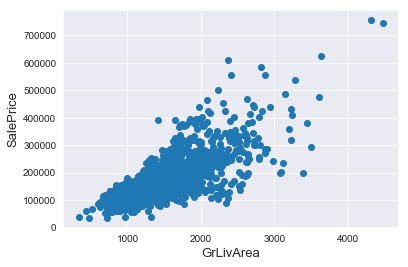

In [7]:
#Deleting outliers (실평수 4000 이상인데 매도가격 300000 이하인 애들)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
# pd.drop 이용해서 위 조건을 만족하는 row의 인덱스를 drop하게됨. axis=0(row-based)이 default이므로 따로 명시하지않음. 

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### 주의사항
- Outlier 모두 제거하는건 약간 위험 요지가 있음. 물론 train data에 아웃라이어가 더 많이 존재할 수 있지만, 이걸 다 제거하면 test set에 존재할 수도있는 outlier 때문에 안좋은 영향을 끼칠수가 있음. 그래서 다 제거시키기 보단, 이런 아웃라이어들을 잘 견딜 수 있도록 모델링 하는 방법을 택했음. 물론 방금 제거한 2명은 해도해도 너무해서 제거한거임.

### Target Variable
- 최종 목표는 SalesPrice 예측이기 때문에 이 변수에 대한 분석을 간단하게 진행해 볼거임

In [8]:
train['SalePrice'].describe()

count     1458.000
mean    180932.919
std      79495.055
min      34900.000
25%     129925.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

- SalePrice는 평균 180932, std 79495 라고 나오는데 이걸 Gaussian Distribution의 파라미터로 넣어주면 해당 값들에 대한 정규분포를 나타낼수있음.


 mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution')

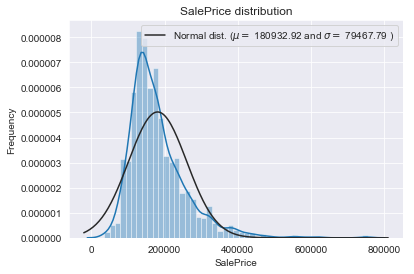

In [9]:
#fit=norm 으로 SalePrice데이터의 평균,표준편차를 가지고있는 정규분포커브를 생성.
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

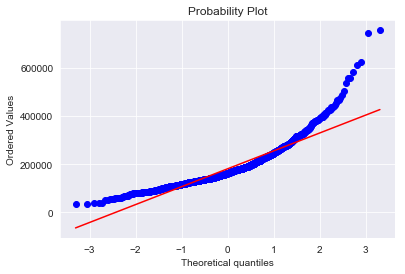

In [10]:
#Probplot이용하여 통계적 분포도를 빨간선으로 표시, 실제 데이터 포인트들을 파란색으로 표시. Default는 Normal Distribution. 분포를 선택가능.
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- Linear 모델들은 정규분포를 좋아라 하는데, 우리 데이터는 Right-skewed이므로 더 정규분포스럽게 변환시켜줘야할 필요가 있음.
- Natural Log(1+x) 사용


 mu = 12.02 and sigma = 0.40



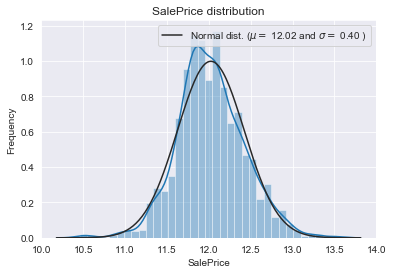

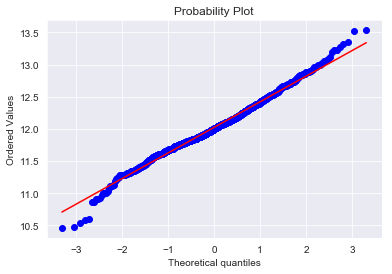

In [11]:
#We use the numpy fuction log1p which  applies ln(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## Feature Engineering
- Feature들을 가지고 놀거기 때문에 Train/Test 를 먼저 합쳐줘야함

In [12]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True) # 데이터프레임 두개를 합치는거니까 각자 따로노는 index를 없애줌.
all_data.drop(['SalePrice'], axis=1, inplace=True) # y는 FE에서 필요없으므로 제외.
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Missing Values

In [13]:
# all_data라는 DF에서 all_data_na라는 Series 생성.
# all_data.isnull().sum() -> null값의 개수를 합한 시리즈.
# len(all_data) -> DF의 사이즈. 즉, Row의 크기.
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100 

#0인 인덱스를 다 날려버리고 상위 30개로 Sort.
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

#Missing Ratio 컬럼에 all_data_na라는 시리즈를 넣고 missing_data라는 df로 생성.
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

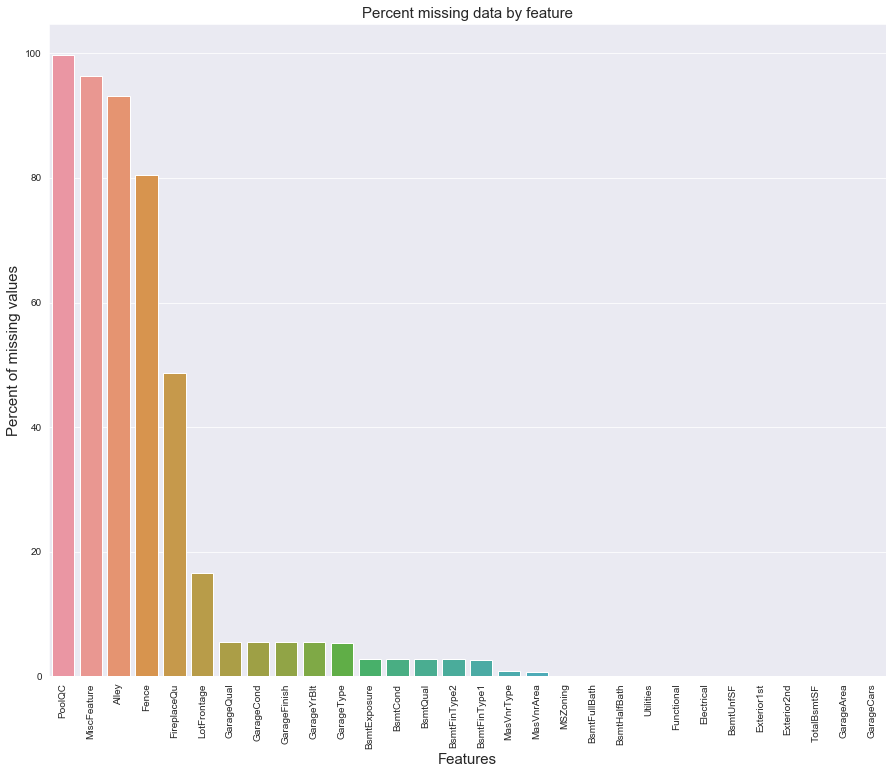

In [14]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90') #표시되는 X를 90도 돌려주는거. 가로로 되있는게 Default인데 이러면 x끼리 겹침.
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

### Missing Data Imputation
- 결측치 처리할때는 항상 각 변수별로 따로 고려를 해줘야함.

In [15]:
# PoolQC : Pool Quality. 대부분의 집에 풀이 없다는 걸 전제로 null로 인식하게 하면 안되고 None으로 바꿔줘야됨.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [16]:
# MiscFeature : 집의 특이사항. 마찬가지로 null이 아니라 None.
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [17]:
# Alley, Fence, FireplaceQu 모두 마찬가지로 None.
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- LotFrontage : 집과 집 사이를 연결하는 도로의 길이. 어케처리해야할까요?

In [18]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [19]:
# GarageType, GarageFinish, GarageQual and GarageCond 등은 차고가 없으면 없다고 표기되었을 것이므로 None으로.
all_data.update(all_data[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna('None'))

In [20]:
# GarageYrBlt, GarageArea and GarageCars 들은 차고관련 수치 변수인데, 차고가 없을때 0으로 표기하는게 맞을듯.
all_data.update(all_data[["GarageYrBlt","GarageArea","GarageCars"]].fillna(0))

In [21]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath
# 얘네들은 집의 Basement 층 관련 변수중 수치형 변수들로 missing일때는 아마도 Basement층이 없는 것이므로 0으로 처리.
all_data.update(all_data[["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath"]].fillna(0))

In [22]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 범주형이므로 None 으로 처리
all_data.update(all_data[["BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2"]].fillna('None'))

In [23]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [24]:
# MSZoning : 집의 구역 타입. 구역은 항상 어떤 타입에 속해있는걸로 보여지기 때문에 가장 frequent 한 타입으로 결측값 처리.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [25]:
# Utilities 어케생겻는지 살펴봅시다.
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [26]:
# 모델에 도움이 하나도 안되겟죠? 드랍합니다.
all_data.drop(['Utilities'],axis=1,inplace=True)

In [27]:
# Functional: 집의 상태. 앵간하면 Typ이고 뭔가이상이 있어면 다른 카테고리로 분류된다고 하니 앵간할 경우를 결측치의 처리값으로 넣어줌.
all_data['Functional'].fillna('Typ',inplace=True)

In [28]:
# Electrical : 집의 전기 공급 구조. 
all_data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [29]:
# 이건그냥 가장 빈도수 높은 SBrkr로 대체합시다.
all_data['Electrical'].fillna(all_data['Electrical'].mode()[0],inplace=True)

In [30]:
# KitchenQual : 주방 퀄. 마찬가지로 하나의 결측치만 있음.
all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0],inplace=True)

In [31]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [32]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


# More Feature Engineering

In [33]:
# 범주형이어야할 수치형 변수들을 스트링으로 변환
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['OverallQual'] = all_data['OverallQual'].astype(str)

In [34]:
# 오다가 존재한다고 생각하는 몇몇 카테고리컬 변수들을 레이블인코더로 변환.
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold','OverallQual')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [35]:
#집값 예측에 집의 토탈 평수가 중요하므로 그에따른 변수 생성.
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewness Handle

In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [37]:
# skewness rule of thumb => abs(1) 부터 highly skewed. 여기선 더 정확하게 0.75로 했네요.
# normalize 하는 방법으로 log1p 도 있지만 여기선 boxcox1p를 사용했는데 둘의 차이는 추후에 공부하는걸로
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 36 skewed numerical features to Box Cox transform


In [38]:
# categorical variables 중 nominal 인 애들 OHE
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [39]:
#FE 끝! 다시 train/test 로 partition lesgitit
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

In [40]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [41]:
# sklearn에서 제공하는 cross_val_score에는 셔플기능이 없다고 해서 함수 생성
def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=cv))
    return(score)


## Base Models
#### LASSO
- Linear Regression -> Minimize MSE
- LASSO Regression -> Minimize MSE + Penalty(alpha*L1-Norm) <- L1-Norm 은 가중치의 합.
- 결과적으로 alpha의 값이 크면 거의 모든 변수들의 가중치가 0이 됨.
- Feature가 엄청나게 많은 데이터에 유용(왜냐면 다중공선성 있는 변수들 알아서 처리해버리니까
- Feature Selection 을 결과적으로 하게 해주는 모델. 모델 해석력 떡상!
- 주의사항으로는 outlier에 상당히 민감할수밖에없다. 그래서 outlier에 대해 저항력을 가지게 해주는 Robustscaler()방법을 씀.

In [42]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#### Elastic Net Regression 
- Ridge(L2) + LASSO(L1)
- L1이 가중치들의 절대값의 합을 최소화 시키는 페널티라면, L2는 가중치들의 제곱의 합을 최소화 시키는 페널티.
- L1은 알파가 클수록 많은 변수들이 0이 되면서 변수삭제기능이 있지만, L2는 0에가까워지되 변수가 삭제되지는 않음.
- 두개중 어떤걸 쓸지 하이퍼파라미터에서 결정 가능. (alpha가 1일때 L1사용, 0일때 Ridge사용.)
- 결과적으로 두개의 중간결과를 예상 가능요!

In [43]:
#ElasticNet의 파라미터중 l1_ratio를 0.9로 함으로써 L1을 더 비중있게 사용할 거임
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [44]:
# KRR은 Ridge Regression에 Kernel trick 얹은거.
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [45]:
#GBR - Huber Loss가 outlier에대해 저항력 생성해준다는거
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [46]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                              random_state = 7,nthread = -1)

In [47]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base Models

In [48]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1153 (0.0082)



In [49]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1154 (0.0082)



In [50]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1890 (0.0243)



In [51]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1163 (0.0092)



In [68]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1176 (0.0080)



In [53]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1174 (0.0092)



# Stacking

In [56]:
from mlxtend.regressor import StackingCVRegressor

In [57]:
stack_gen = StackingCVRegressor(regressors=(KRR, lasso, ENet, GBoost, model_xgb, model_lgb),
                                meta_regressor=model_xgb,
                                use_features_in_secondary=True)

In [59]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(train), np.array(y_train))

print('elasticnet')
elastic_model_full_data = ENet.fit(train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(train, y_train)

print('Ridge')
ridge_model_full_data = KRR.fit(train, y_train)

print('GradientBoosting')
gbr_model_full_data = GBoost.fit(train, y_train)

print('xgboost')
xgb_model_full_data = model_xgb.fit(train, y_train)

print('lightgbm')
lgb_model_full_data = model_lgb.fit(train, y_train)

START Fit
stack_gen
elasticnet
Lasso
Ridge
GradientBoosting
xgboost
lightgbm


In [61]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [70]:
stacked_train_pred = stack_gen_model.predict(np.array(train))
rmsle(y_train, stacked_train_pred)

0.06576642581122533

In [71]:
xgb_train_pred = xgb_model_full_data.predict(train)
rmsle(y_train, xgb_train_pred)

0.07839964078604958

In [72]:
lgb_train_pred = lgb_model_full_data.predict(train)
rmsle(y_train, lgb_train_pred)

0.07393383485565476

In [75]:
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

0.06643622678047899
